### 고객 대출등급 예측 AI 알고리즘 개발

In [41]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv("C:/Users/sori4/Downloads/(자체) 고객 대출등급 분류 해커톤/data/test.csv")
train_df = pd.read_csv("C:/Users/sori4/Downloads/(자체) 고객 대출등급 분류 해커톤/data/train.csv")

### EDA

In [42]:
train_df.shape, test_df.shape #'대출등급' columns 예측

((96294, 15), (64197, 14))

In [43]:
drop_col = ['ID']
int_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수']
#다른 변경 필요 : '대출기간', '근로기간'
str_col = ['주택소유상태', '대출목적']
y_col = ['대출등급']

In [44]:
train_df['대출기간'].unique() #[' 36 months', ' 60 months']
train_df['근로기간'].unique() # <1 < 1 이있고 10+ 10 +가 있어서 합치는 게 필요함
train_df['주택소유상태'].unique() #['RENT', 'MORTGAGE', 'OWN', 'ANY']
train_df['대출목적'].unique() # ['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업', '기타', '이사', '주택', '재생 에너지']

array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
       '기타', '이사', '주택', '재생 에너지'], dtype=object)

<Axes: ylabel='총연체금액'>

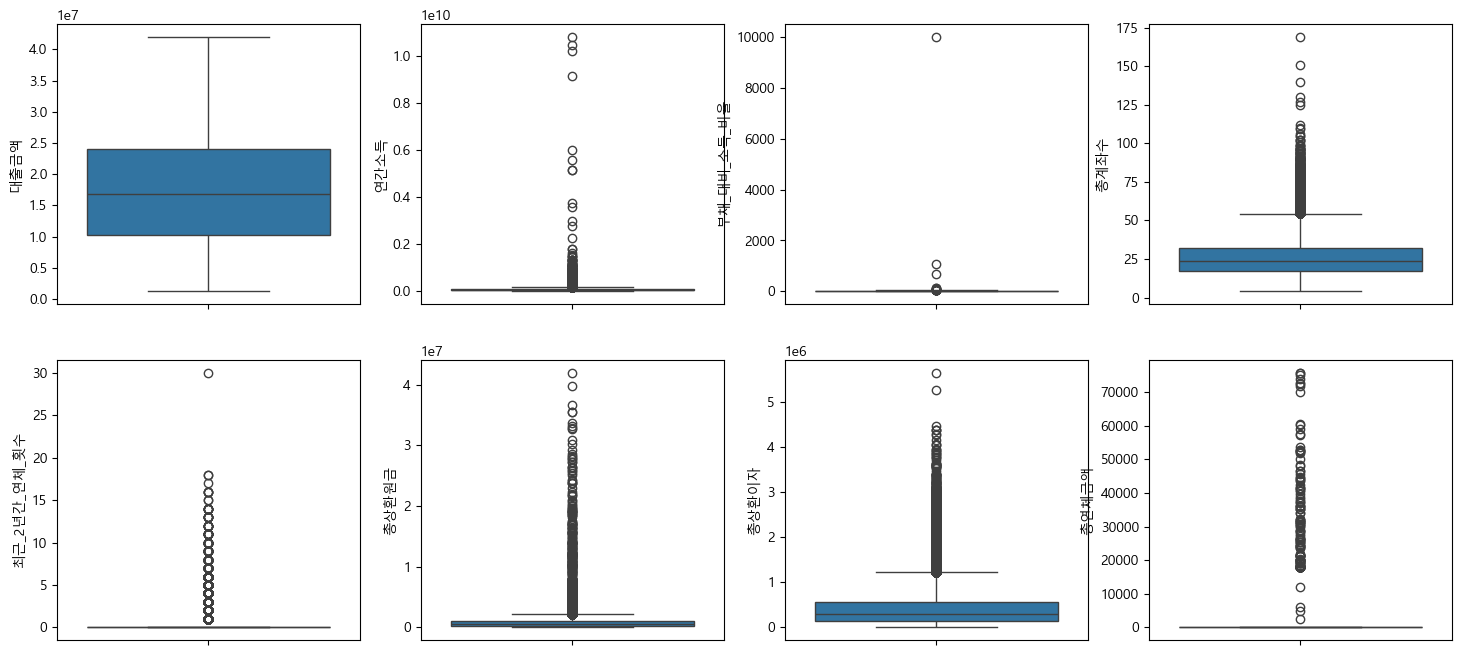

In [45]:
#이상치 체크
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns

f_path = 'C:\Windows\Fonts\malgun.ttf'
font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')

fig, axes = plt.subplots(2, 4, figsize = (18, 8))

sns.boxplot(train_df['대출금액'], ax=axes[0, 0])
sns.boxplot(train_df['연간소득'], ax=axes[0, 1])
sns.boxplot(train_df['부채_대비_소득_비율'], ax=axes[0, 2])
sns.boxplot(train_df['총계좌수'], ax=axes[0, 3])
sns.boxplot(train_df['최근_2년간_연체_횟수'], ax=axes[1, 0])
sns.boxplot(train_df['총상환원금'], ax=axes[1, 1])
sns.boxplot(train_df['총상환이자'], ax=axes[1, 2])
sns.boxplot(train_df['총연체금액'], ax=axes[1, 3])

<Axes: ylabel='연체계좌수'>

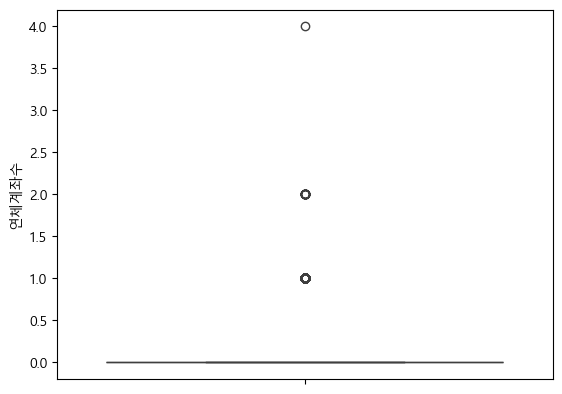

In [46]:
sns.boxplot(train_df['연체계좌수'])

### 전처리

In [47]:
#범주형 인코딩
train_df['근로기간'].unique()
# #'< 1' 전처리
# test_df['근로기간'].unique()

array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
       '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
       '10+years', '<1 year', '3', '1 years'], dtype=object)

In [48]:
#예측할 값 분리
y = train_df[y_col]
train_df.drop(columns=y_col, inplace=True)

In [49]:
#'대출기간', '근로기간' 전처리 함수 만들기
def preprocessing_df(df):
    #근로기간 전처리
    df.loc[df['근로기간'] == '< 1 year', '근로기간'] = '<1 year'
    df.loc[df['근로기간'] == '10+years', '근로기간'] = '10+ years'

    df['근로기간'] = df['근로기간'].str.split(' ').apply(lambda x: x[0])
    df['근로기간'] = pd.to_numeric(df['근로기간'], errors='coerce') #Unknown을 Nan으로 변경
    df.loc[df['근로기간'] == '<1', '근로기간'] = '0'
    df.loc[df['근로기간'] == '10+', '근로기간'] = '10'

    df['근로기간'] = df['근로기간'].astype('float')

    #대출기간 전처리
    df['대출기간'] = df['대출기간'].apply(lambda row: 1 if row == ' 36 months' else 2)

    #불필요한 열 삭제
    df.drop(columns = drop_col, inplace=True)

    return df


In [50]:
#대출기간, 근로기간 전처리 진행
train_df_scaled = preprocessing_df(train_df)
test_df_scaled = preprocessing_df(test_df)

In [51]:
#범주형 전처리
from sklearn.preprocessing import LabelEncoder, RobustScaler

encoder = LabelEncoder()
scaler = RobustScaler()

#데이터 합쳐서 범주형 처리
df = pd.concat([train_df, test_df], axis=0)
df['주택소유상태'] = encoder.fit_transform(df['주택소유상태'])
df['대출목적'] = encoder.fit_transform(df['대출목적'])

#train, test 다시 나누기
train_df_scaled = df.iloc[:96294, :]
test_df_scaled = df.iloc[96294:, :]

train_df.shape, train_df_scaled.shape, test_df.shape, test_df_scaled.shape #크기 동일 확인

((96294, 13), (96294, 13), (64197, 13), (64197, 13))

In [52]:
#수치형 인코딩
train_df_scaled2 = scaler.fit_transform(train_df_scaled)
test_df_scaled2 = scaler.transform(test_df_scaled)

In [53]:
#y값에 대한 인코딩도 필요
label_order = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}

# 라벨 인코더 생성 및 순서 정의
encoder.classes_ = [label for label, order in sorted(label_order.items(), key=lambda x: x[1])]

# 데이터프레임의 '대출등급' 열에 라벨 인코딩 적용
import numpy as np
# y['대출등급'] = encoder.transform(y['대출등급'])
y_array = np.array(y['대출등급'])
y_array_encoded = encoder.fit_transform(y_array)
y['대출등급'] = y_array_encoded

### 예측모델

In [ ]:
#분류 모델 : 